In [58]:
from __future__ import print_function, division

import torch
from torchvision import transforms, utils, models
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from sklearn.model_selection import StratifiedKFold

import time
import copy

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
root_dir = '/content/gdrive/MyDrive/shenzhen_tubeculosis/images/images'
csv_path = '/content/gdrive/MyDrive/shenzhen_tubeculosis/shenzhen_metadata.csv'

In [12]:
df = pd.read_csv(csv_path)

In [14]:
df.head(5)

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [69]:
class TubeDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.to_list()

        img_name = self.csv_file['study_id'][idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path)
        label = int(img_name[12])  # CHNCXR_0659_1.png
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (2919, 3000)
1 (2951, 3000)
2 (2945, 2987)
3 (2933, 3000)


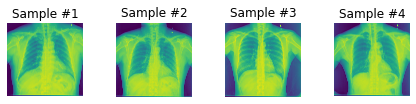

In [25]:
tube_dataset = TubeDataset(csv_file=df, root_dir=root_dir)
fig = plt.figure()

n_show = 4
for i in range(n_show):
    sample = tube_dataset[i]
    
    print(i, sample['image'].shape)
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i+1))
    ax.axis('off')
    plt.imshow(sample['image'])

plt.show()

In [26]:
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))  # must be int or tuple
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        label = sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else :
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': label}
    
class RandomCrop(object):

    def __init__(self, output_size):
        
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size
        
    def __call__(self, sample):
        
        image = sample['image']
        label = sample['label']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top:top+new_h,
                      left:left+new_w]

        return {'image': image, 'label': label}

class ToTensor(object):

    def __call__(self, sample):

        image = sample['image']
        label = sample['label']
        image = image.transpose((2, 0, 1))
        return {'image': image, 'label': label}

In [27]:
scale = Rescale(256)
crop = RandomCrop(2500)
composed = transforms.Compose([Rescale(256), RandomCrop(220)])

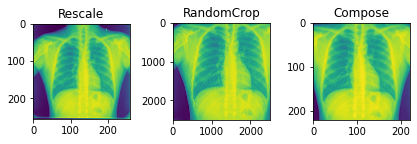

In [28]:
fig = plt.figure()
sample = tube_dataset[23]

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()